# Studying Qinj as a candle for time-walk correction

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from fnmatch import fnmatch
import hist
from hist import Hist

In [3]:
charges = [6]
# thresholds = np.arange(241,600,5)
row = 0
col = 0
delays = [f'0x0{i:x}' for i in range(16)]
delays = delays + [f'0x1{i:x}' for i in range(16)]

def return_empty_list():
    return {q:{d:0 for d in delays} for q in charges}

In [4]:
h = {q:{d:(
           Hist.new.Integer(100, 500, name="CAL", label="CAL [LSB]")
           .Integer(0, 512, name="TOT", label="TOT [LSB]")
           .Integer(0, 1024, name="TOA", label="TOA [LSB]")
           .Double()
          )
      for d in delays} 
     for q in charges}

counts = return_empty_list()
CAL_sum = return_empty_list()
CAL_sum_sq = return_empty_list()
TOA_sum = return_empty_list()
TOA_sum_sq = return_empty_list()
TOT_sum = return_empty_list()
TOT_sum_sq = return_empty_list()

toa_list = []
tot_list = []
cal_list = []

root = '../ETROC-Data'
file_pattern = "*translated*.dat"

for QInj in (charges):
    for delay in (delays):
        print(f'Pixel {col},{row} - {QInj} fC - Delay {delay}')
        path_pattern = f"*E2_testing_VRef_QinjDelay{delay}_C{col}_R{row}"
        file_list = []
        for path, subdirs, files in os.walk(root):
            if not fnmatch(path, path_pattern): continue
            for name in files:
                pass
                if fnmatch(name, file_pattern):
                    file_list.append(os.path.join(path, name))
                    print(file_list[-1])
        current_bcid = -1
        previous_bcid = -1
        total_files = len(file_list)
        for file_index, file_name in enumerate(file_list):
            print(f"{file_index+1}/{total_files}")
            with open(file_name) as infile:
                for line in infile:
                    text_list = line.split()
                    if(text_list[2]=="HEADER"): current_bcid = int(text_list[8])
                    elif(text_list[2]=="TRAILER"): previous_bcid = current_bcid
                    if(previous_bcid==-1 or (current_bcid-previous_bcid==68 if current_bcid>=previous_bcid else current_bcid+3564-previous_bcid==68)): continue
                    if text_list[2]!="DATA": continue
                    c_running = int(text_list[6])
                    r_running = int(text_list[8])
                    TOA = int(text_list[10])
                    TOT = int(text_list[12])
                    CAL = int(text_list[14])
                    if(c_running!=col or r_running!=row): continue
                    # if(CAL>200 or CAL<100): continue
                    CAL_sum[QInj][delay] += CAL
                    CAL_sum_sq[QInj][delay] += CAL*CAL
                    TOA_sum[QInj][delay] += TOA
                    TOA_sum_sq[QInj][delay] += TOA*TOA
                    TOT_sum[QInj][delay] += TOT
                    TOT_sum_sq[QInj][delay] += TOT*TOT
                    counts[QInj][delay] += 1 
                    h[QInj][delay].fill(CAL,TOT,TOA)
                    toa_list.append(TOA)
                    tot_list.append(TOT)
                    cal_list.append(CAL)
toa_list = np.array(toa_list)
tot_list = np.array(tot_list)
cal_list = np.array(cal_list)

Pixel 0,0 - 6 fC - Delay 0x00
../ETROC-Data/2023-05-22_Array_Test_Results/E2_testing_VRef_QinjDelay0x00_C0_R0/TDC_Data_translated_2.dat
../ETROC-Data/2023-05-22_Array_Test_Results/E2_testing_VRef_QinjDelay0x00_C0_R0/TDC_Data_translated_3.dat
../ETROC-Data/2023-05-22_Array_Test_Results/E2_testing_VRef_QinjDelay0x00_C0_R0/TDC_Data_translated_1.dat
../ETROC-Data/2023-05-22_Array_Test_Results/E2_testing_VRef_QinjDelay0x00_C0_R0/TDC_Data_translated_0.dat
../ETROC-Data/2023-05-22_Array_Test_Results/E2_testing_VRef_QinjDelay0x00_C0_R0/TDC_Data_translated_4.dat
../ETROC-Data/2023-05-22_Array_Test_Results/E2_testing_VRef_QinjDelay0x00_C0_R0/TDC_Data_translated_5.dat
../ETROC-Data/2023-05-22_Array_Test_Results/E2_testing_VRef_QinjDelay0x00_C0_R0/TDC_Data_translated_7.dat
../ETROC-Data/2023-05-22_Array_Test_Results/E2_testing_VRef_QinjDelay0x00_C0_R0/TDC_Data_translated_6.dat
1/8
2/8
3/8
4/8
5/8
6/8
7/8
8/8
Pixel 0,0 - 6 fC - Delay 0x01
../ETROC-Data/2023-05-22_Array_Test_Results/E2_testing_VRef_

In [8]:
CAL_mean = return_empty_list()
CAL_std = return_empty_list()
TOA_mean = return_empty_list()
TOA_std = return_empty_list()
TOT_mean = return_empty_list()
TOT_std = return_empty_list()
for Qinj in charges:
    for delay in delays:
        if counts[Qinj][delay]==0: continue
        CAL_mean[Qinj][delay] = CAL_sum[Qinj][delay]/counts[Qinj][delay]
        CAL_std[Qinj][delay] = np.sqrt((CAL_sum_sq[Qinj][delay]/counts[Qinj][delay]) - pow(CAL_mean[Qinj][delay], 2))
        TOA_mean[Qinj][delay] = TOA_sum[Qinj][delay]/counts[Qinj][delay]
        TOA_std[Qinj][delay] = np.sqrt((TOA_sum_sq[Qinj][delay]/counts[Qinj][delay]) - pow(TOA_mean[Qinj][delay], 2))
        TOT_mean[Qinj][delay] = TOT_sum[Qinj][delay]/counts[Qinj][delay]
        TOT_std[Qinj][delay] = np.sqrt((TOT_sum_sq[Qinj][delay]/counts[Qinj][delay]) - pow(TOT_mean[Qinj][delay], 2))

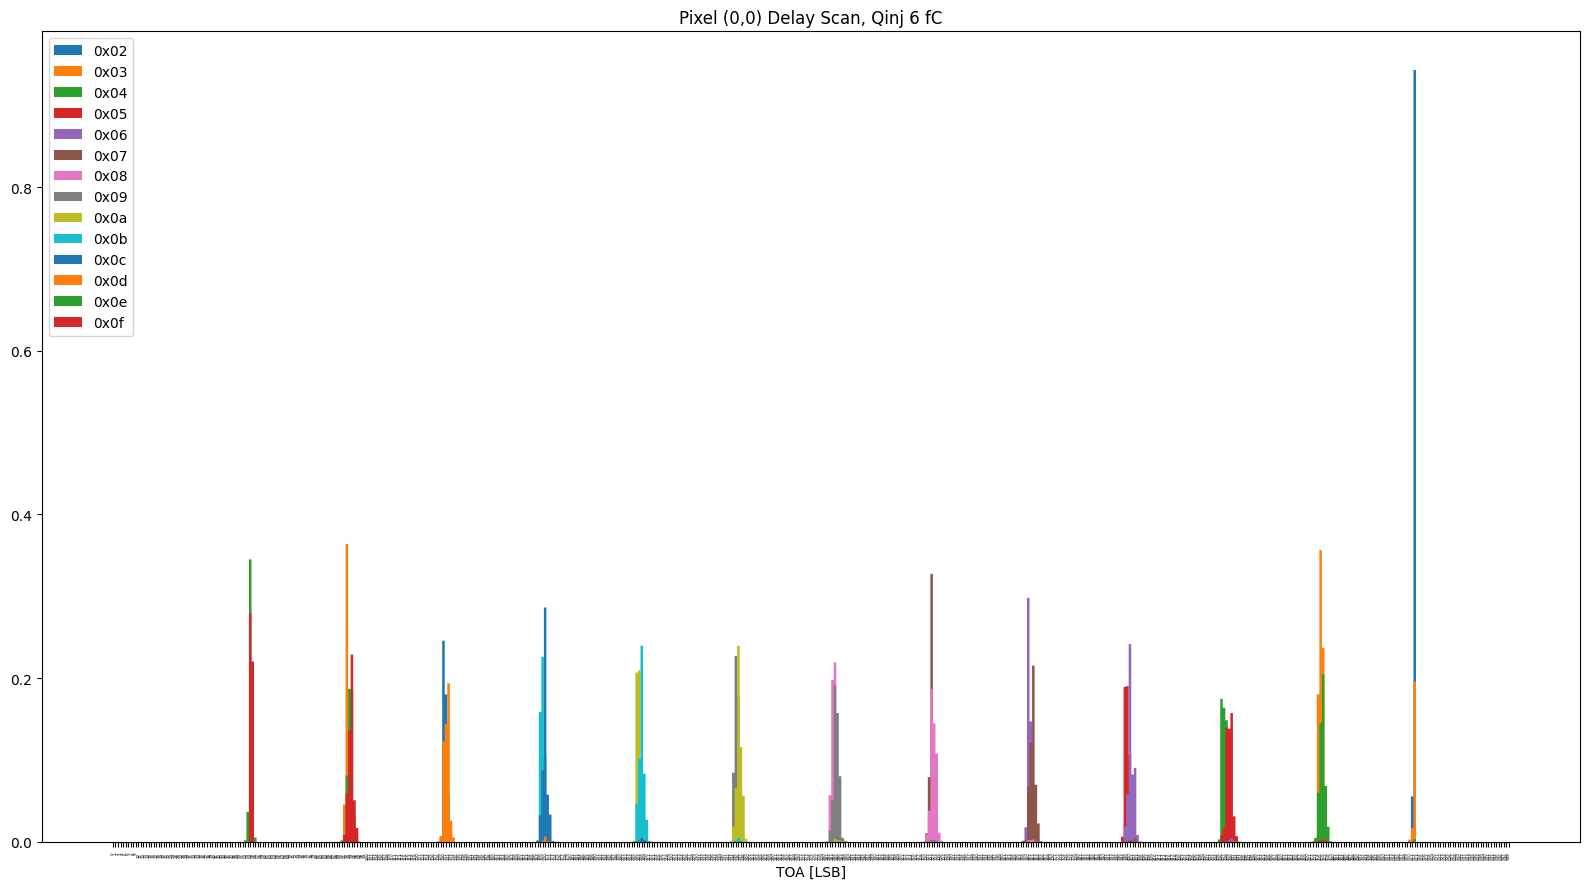

In [9]:
fig = plt.figure(dpi=100, figsize=(16,9))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0,0])
for Qinj in charges:
    for delay in delays[2:16]:
        # ax0.axvline(BL_map_THCal[row][col], color='r', label="THCal BL")
        if counts[Qinj][delay]==0: continue
        # h[Qinj][delay].project("TOA").plot1d(ax=ax, lw=1, histtype="fill")
        # h[Qinj][delay].project("TOA").plot1d(ax=ax, lw=1, marker='.', histtype="errorbar", fillstyle='full', xerr=True, 
        #                               capsize=2, markersize=5, label=f'{delay}')
        h[Qinj][delay].project("TOA")[0j:550j].plot1d(ax=ax, histtype="fill",label=f'{delay}', density=True)
        # ax.text(0.1, 0.9, f"Mean: {CAL_mean[Qinj][delay]:.2f}", ha="left", va="center", fontweight="bold", c="black", size=15, transform=ax.transAxes)
        # ax.text(0.1, 0.8, f"Std: {CAL_std[Qinj][delay]:.2f}", ha="left", va="center", fontweight="bold", c="black", size=15, transform=ax.transAxes)
ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(), rotation='vertical', size=3)
plt.legend(loc="upper left")
ax.set_title(f"Pixel ({0},{0}) Delay Scan, Qinj {charges[0]} fC")
plt.tight_layout()
# plt.savefig("figures/CAL_0_0.pdf")
plt.show()

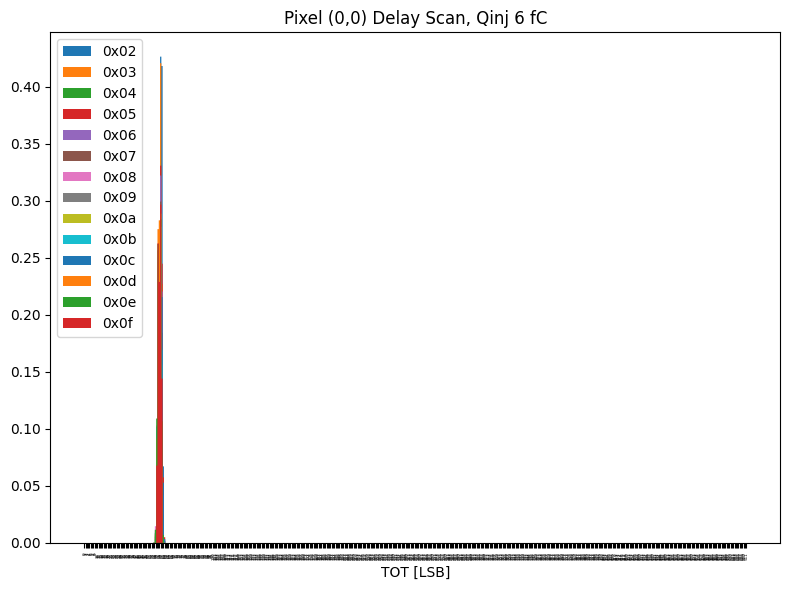

In [10]:
fig = plt.figure(dpi=100, figsize=(8,6))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0,0])
for Qinj in charges:
    for delay in delays[2:16]:
        # ax0.axvline(BL_map_THCal[row][col], color='r', label="THCal BL")
        if counts[Qinj][delay]==0: continue
        # h[Qinj][delay].project("TOA").plot1d(ax=ax, lw=1, histtype="fill")
        # h[Qinj][delay].project("TOA").plot1d(ax=ax, lw=1, marker='.', histtype="errorbar", fillstyle='full', xerr=True, 
        #                               capsize=2, markersize=5, label=f'{delay}')
        h[Qinj][delay].project("TOT")[0j:].plot1d(ax=ax, histtype="fill",label=f'{delay}', density=True)
        # ax.text(0.1, 0.9, f"Mean: {CAL_mean[Qinj][delay]:.2f}", ha="left", va="center", fontweight="bold", c="black", size=15, transform=ax.transAxes)
        # ax.text(0.1, 0.8, f"Std: {CAL_std[Qinj][delay]:.2f}", ha="left", va="center", fontweight="bold", c="black", size=15, transform=ax.transAxes)
ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(), rotation='vertical', size=3)
plt.legend(loc="upper left")
ax.set_title(f"Pixel ({0},{0}) Delay Scan, Qinj {charges[0]} fC")
plt.tight_layout()
# plt.savefig("figures/CAL_0_0.pdf")
plt.show()

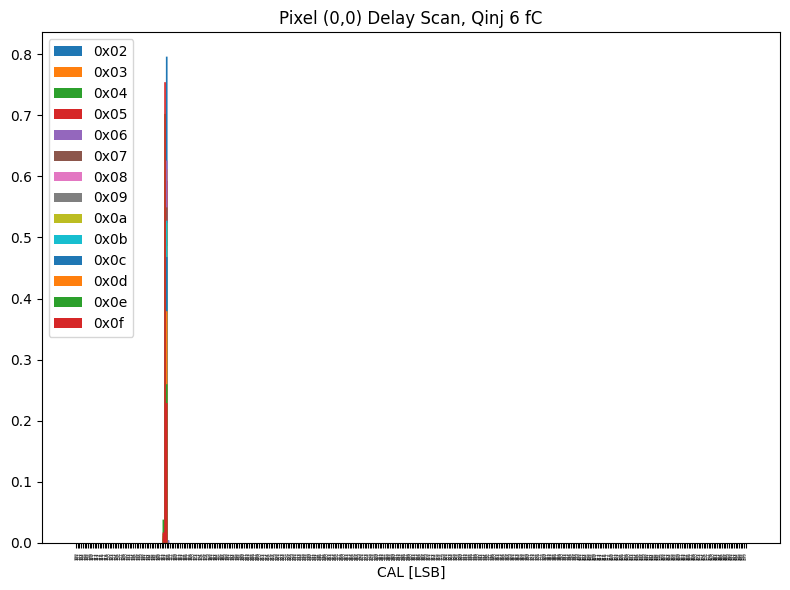

In [11]:
fig = plt.figure(dpi=100, figsize=(8,6))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0,0])
for Qinj in charges:
    for delay in delays[2:16]:
        # ax0.axvline(BL_map_THCal[row][col], color='r', label="THCal BL")
        if counts[Qinj][delay]==0: continue
        # h[Qinj][delay].project("TOA").plot1d(ax=ax, lw=1, histtype="fill")
        # h[Qinj][delay].project("TOA").plot1d(ax=ax, lw=1, marker='.', histtype="errorbar", fillstyle='full', xerr=True, 
        #                               capsize=2, markersize=5, label=f'{delay}')
        h[Qinj][delay].project("CAL")[0j:].plot1d(ax=ax, histtype="fill",label=f'{delay}', density=True)
        # ax.text(0.1, 0.9, f"Mean: {CAL_mean[Qinj][delay]:.2f}", ha="left", va="center", fontweight="bold", c="black", size=15, transform=ax.transAxes)
        # ax.text(0.1, 0.8, f"Std: {CAL_std[Qinj][delay]:.2f}", ha="left", va="center", fontweight="bold", c="black", size=15, transform=ax.transAxes)
ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(), rotation='vertical', size=3)
plt.legend(loc="upper left")
ax.set_title(f"Pixel ({0},{0}) Delay Scan, Qinj {charges[0]} fC")
plt.tight_layout()
# plt.savefig("figures/CAL_0_0.pdf")
plt.show()

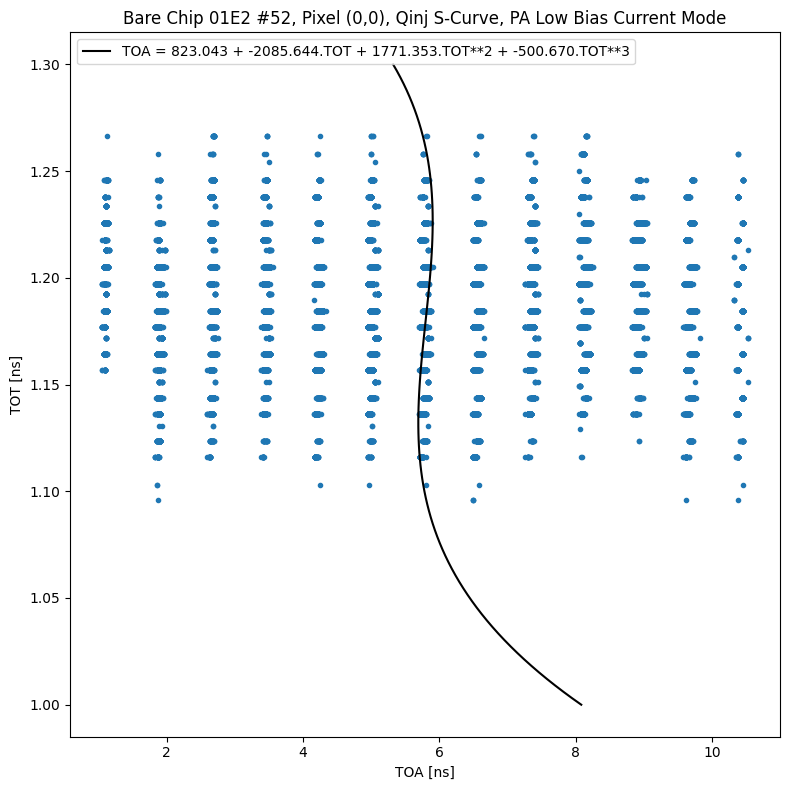

In [7]:
fig = plt.figure(dpi=100, figsize=(8,8))
gs = fig.add_gridspec(1,1)
ax0 = fig.add_subplot(gs[0,0])
code_conversion = 3.125/(cal_list)
ax0.plot(code_conversion*toa_list, code_conversion*tot_list, '.')
p, cov = np.polyfit(code_conversion*tot_list, code_conversion*toa_list, 3, cov = True)
n = tot_list.size
x_range = np.linspace(1, 1.3, 100)
Yest = np.polyval(p, x_range)
ax0.plot(Yest, x_range, 'k-', label=f'TOA = {p[-1]:.3f} + {p[-2]:.3f}.TOT + {p[-3]:.3f}.TOT**2 + {p[-4]:.3f}.TOT**3')
ax0.set_xlabel("TOA [ns]")
ax0.set_ylabel("TOT [ns]")
plt.title(f"Bare Chip 01E2 #52, Pixel ({row},{col}), Qinj S-Curve, PA Low Bias Current Mode")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("figures/toa_vs_tot_scurve.pdf")
plt.show()